# TransUNet on EndoVis2017 (Colab Notebook)

This notebook sets up **TransUNet** for **EndoVis2017** surgical instrument **semantic segmentation** with 8 classes (0–7).  
It includes a small, optional **smoke test** that only runs if the dataset path is missing, so you can verify the pipeline wiring.


## 1) Runtime and Drive

In [1]:
# If you are in Google Colab, set Runtime -> Change runtime type -> GPU
# Then mount your Drive so the dataset and checkpoints are available
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    IN_COLAB = False
print('In Colab:', IN_COLAB)

Mounted at /content/drive
In Colab: True


## 2) Install dependencies and clone TransUNet

In [3]:
# Core deps
!pip -q install timm einops ml-collections --extra-index-url https://download.pytorch.org/whl/cu121 || true

# Get TransUNet repo
!git clone -q https://github.com/Beckschen/TransUNet.git || true
%cd TransUNet

# Make sure Python can import the networks package
!python - << 'PY'
import os
os.makedirs('networks', exist_ok=True)
open('networks/__init__.py', 'a').close()
print('Ensured networks package header exists')


/content/TransUNet/TransUNet
/bin/bash: line 1: warning: here-document at line 1 delimited by end-of-file (wanted `PY')
Ensured networks package header exists


## 3) Set paths and label mapping

In [4]:
# Set your dataset root here (folder must contain imagesTr, labelsTr, imagesTs, labelsTs)
# Example for Colab: '/content/drive/MyDrive/data/EndoVis2017'
DATA_ROOT = '/content/drive/MyDrive/HMC_Work/EndoVis2017_Split'

CLASS_ID_MAP = {
    'Background': 0,
    'Bipolar Forceps': 1,
    'Prograsp Forceps': 2,
    'Large Needle Driver': 3,
    'Vessel Sealer': 4,
    'Grasping Retractor': 5,
    'Monopolar Curved Scissors': 6,
    'Other': 7,
}
NUM_CLASSES = 8
IMG_SIZE = 224  # TransUNet 2D default
BATCH_SIZE = 2
EPOCHS = 5  # increase for real training
LR = 1e-4
CKPT_DIR = '/content/TransUNet_ckpts' if IN_COLAB else './TransUNet_ckpts'

import os
os.makedirs(CKPT_DIR, exist_ok=True)
print('DATA_ROOT =', DATA_ROOT)
print('Checkpoints ->', CKPT_DIR)

DATA_ROOT = /content/drive/MyDrive/HMC_Work/EndoVis2017_Split
Checkpoints -> /content/TransUNet_ckpts


### Expected folder structure

```
EndoVis2017/
├── imagesTr/   # training RGB images (.png/.jpg)
├── labelsTr/   # training masks (PNG, integer pixels in [0..7])
├── imagesTs/   # test RGB images
├── labelsTs/   # test masks (optional but needed for evaluation)
```
- Masks must be single-channel PNGs with integer values 0..7.  
- If your dataset is arranged per sequence, consolidate into the above split or adapt the `EndoVisDataset` below (folder walking is simple).


## 4) PyTorch dataset and transforms

In [5]:
import os, glob
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as T

class EndoVisDataset(Dataset):
    def __init__(self, root: str, split: str = 'train', img_size: int = 224):
        assert split in {'train', 'test'}
        img_dir = 'imagesTr' if split == 'train' else 'imagesTs'
        mask_dir = 'labelsTr' if split == 'train' else 'labelsTs'
        self.img_paths = sorted(glob.glob(os.path.join(root, img_dir, '*')))
        self.mask_paths = [os.path.join(root, mask_dir, os.path.basename(p)) for p in self.img_paths]
        self.img_size = img_size
        self.to_tensor = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])
        self.mask_resize = T.Resize((img_size, img_size), interpolation=T.InterpolationMode.NEAREST)

    def __len__(self):
        return len(self.img_paths)

    def _load_mask(self, path: str):
        m = Image.open(path).convert('L')  # single channel
        m = self.mask_resize(m)
        m = np.array(m, dtype=np.uint8)
        return torch.from_numpy(m).long()

    def __getitem__(self, idx: int):
        img = Image.open(self.img_paths[idx]).convert('RGB')
        mask = self._load_mask(self.mask_paths[idx])
        img = self.to_tensor(img)
        # Sanity: constrain labels to [0..7]
        mask = torch.clamp(mask, 0, 7)
        return img, mask

# Verify availability or fall back to smoke test
has_data = os.path.isdir(DATA_ROOT) and \
           os.path.isdir(os.path.join(DATA_ROOT, 'imagesTr')) and \
           os.path.isdir(os.path.join(DATA_ROOT, 'labelsTr'))

if has_data:
    train_ds = EndoVisDataset(DATA_ROOT, 'train', IMG_SIZE)
    test_ds  = EndoVisDataset(DATA_ROOT, 'test',  IMG_SIZE)
else:
    # Smoke test: tiny synthetic dataset (clearly marked)
    print('WARNING: DATA_ROOT missing. Running SMOKE TEST with synthetic tensors ONLY to verify pipeline.')
    class _Toy(torch.utils.data.Dataset):
        def __len__(self): return 8
        def __getitem__(self, i):
            x = torch.rand(3, IMG_SIZE, IMG_SIZE)
            y = torch.randint(0, 8, (IMG_SIZE, IMG_SIZE))
            return x, y
    train_ds, test_ds = _Toy(), _Toy()

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

print(f'Train samples: {len(train_ds)} | Test samples: {len(test_ds)}')

Train samples: 650 | Test samples: 100


In [6]:
import ml_collections

def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1

    config.classifier = 'seg'
    config.representation_size = None
    config.resnet_pretrained_path = None
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_16.npz'
    config.patch_size = 16

    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'
    return config


def get_testing():
    """Returns a minimal configuration for testing."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 1
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 1
    config.transformer.num_heads = 1
    config.transformer.num_layers = 1
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

def get_r50_b16_config():
    """Returns the Resnet50 + ViT-B/16 configuration."""
    config = get_b16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.n_skip = 3
    config.activation = 'softmax'

    return config


def get_b32_config():
    """Returns the ViT-B/32 configuration."""
    config = get_b16_config()
    config.patches.size = (32, 32)
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_32.npz'
    return config


def get_l16_config():
    """Returns the ViT-L/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 1024
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 4096
    config.transformer.num_heads = 16
    config.transformer.num_layers = 24
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.representation_size = None

    # custom
    config.classifier = 'seg'
    config.resnet_pretrained_path = None
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-L_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'
    return config


def get_r50_l16_config():
    """Returns the Resnet50 + ViT-L/16 configuration. customized """
    config = get_l16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.resnet_pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.activation = 'softmax'
    return config


def get_l32_config():
    """Returns the ViT-L/32 configuration."""
    config = get_l16_config()
    config.patches.size = (32, 32)
    return config


def get_h14_config():
    """Returns the ViT-L/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (14, 14)})
    config.hidden_size = 1280
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 5120
    config.transformer.num_heads = 16
    config.transformer.num_layers = 32
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None

    return config

CONFIGS = {
    'ViT-B_16': get_b16_config(),
    'R50-ViT-B_16': get_r50_b16_config(),
    'ViT-B_32': get_b32_config(),
    'ViT-L_16': get_l16_config(),
    'R50-ViT-L_16': get_r50_l16_config(),
    'ViT-L_32': get_l32_config(),
    'ViT-H_14': get_h14_config(),
    'testing': get_testing()
}

__all__ = ['CONFIGS']

## 5) Build TransUNet model

In [10]:
import torch
import torch.nn as nn
from networks.vit_seg_modeling import VisionTransformer as ViT_seg


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cfg_key = 'R50-ViT-B_16'  # ResNet50 + ViT-B/16 encoder
config = CONFIGS[cfg_key]
config.n_classes = NUM_CLASSES
config.n_skip = 3
ph, pw = config.patches.size if isinstance(config.patches.size, (tuple, list)) else (config.patches.size, config.patches.size)
config.patches.grid = (IMG_SIZE // ph, IMG_SIZE // pw)


model = ViT_seg(config, img_size=IMG_SIZE, num_classes=NUM_CLASSES).to(device)
print('Model params:', sum(p.numel() for p in model.parameters())//1_000_000, 'M')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

Model params: 105 M


## 6) Train (adjust EPOCHS for real runs)

In [11]:
from tqdm import tqdm

best_mIoU = -1.0
best_path = os.path.join(CKPT_DIR, 'transunet_best.pth')

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for x, y in tqdm(train_loader, desc=f'Epoch {epoch}/{EPOCHS}', leave=False):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / max(1, len(train_loader))
    print(f'Epoch {epoch} - Train loss: {avg_loss:.4f}')

    # quick val on a few test samples
    model.eval()
    import torch.nn.functional as F
    iou_sum, n_count = 0.0, 0
    with torch.inference_mode():
        for i, (x, y) in enumerate(test_loader):
            if i >= 16:  # speed
                break
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            # mIoU per image (macro over classes present in either pred or y)
            ious = []
            for c in range(NUM_CLASSES):
                inter = torch.logical_and(pred==c, y==c).sum().item()
                union = torch.logical_or(pred==c, y==c).sum().item()
                if union > 0:
                    ious.append(inter/union)
            if ious:
                iou_sum += sum(ious)/len(ious)
                n_count += 1
    mIoU = iou_sum / max(1, n_count)
    print(f'Epoch {epoch} - Quick mIoU (subset): {mIoU:.4f}')

    if mIoU > best_mIoU:
        best_mIoU = mIoU
        torch.save({'epoch': epoch, 'model': model.state_dict()}, best_path)
        print('Saved:', best_path)

Epoch 1 - Train loss: 1.0425


Epoch 1 - Quick mIoU (subset): 0.7184
Saved: /content/TransUNet_ckpts/transunet_best.pth


Epoch 2 - Train loss: 0.1742


Epoch 2 - Quick mIoU (subset): 0.7523
Saved: /content/TransUNet_ckpts/transunet_best.pth


Epoch 3 - Train loss: 0.0725


Epoch 3 - Quick mIoU (subset): 0.7674
Saved: /content/TransUNet_ckpts/transunet_best.pth


Epoch 4 - Train loss: 0.0506


Epoch 4 - Quick mIoU (subset): 0.7739
Saved: /content/TransUNet_ckpts/transunet_best.pth


Epoch 5 - Train loss: 0.0383


Epoch 5 - Quick mIoU (subset): 0.7668


## 7) Full evaluation on test set

In [12]:
import torch
import numpy as np

model.eval()
cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)
with torch.inference_mode():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(1)
        # confusion matrix accumulation
        for c_true in range(NUM_CLASSES):
            for c_pred in range(NUM_CLASSES):
                cm[c_true, c_pred] += torch.logical_and(y==c_true, pred==c_pred).sum().item()

# Compute per-class IoU and Dice
ious, dices = [], []
for c in range(NUM_CLASSES):
    tp = cm[c, c]
    fp = cm[:, c].sum() - tp
    fn = cm[c, :].sum() - tp
    denom_iou = (tp + fp + fn)
    iou = tp / denom_iou if denom_iou > 0 else float('nan')
    dice = (2*tp) / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else float('nan')
    ious.append(iou)
    dices.append(dice)

mean_iou = np.nanmean(ious)
mean_dice = np.nanmean(dices)
print('Per-class IoU:', [round(float(x), 4) if x==x else None for x in ious])
print('Per-class Dice:', [round(float(x), 4) if x==x else None for x in dices])
print('Mean IoU:', round(float(mean_iou), 4))
print('Mean Dice:', round(float(mean_dice), 4))

Per-class IoU: [0.9892, None, None, None, None, None, None, 0.6346]
Per-class Dice: [0.9946, None, None, None, None, None, None, 0.7765]
Mean IoU: 0.8119
Mean Dice: 0.8855


## 8) Visualize predictions

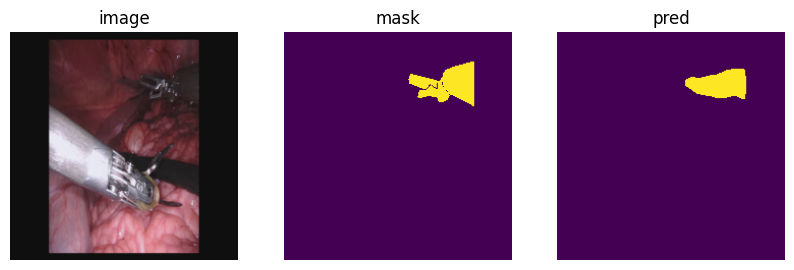

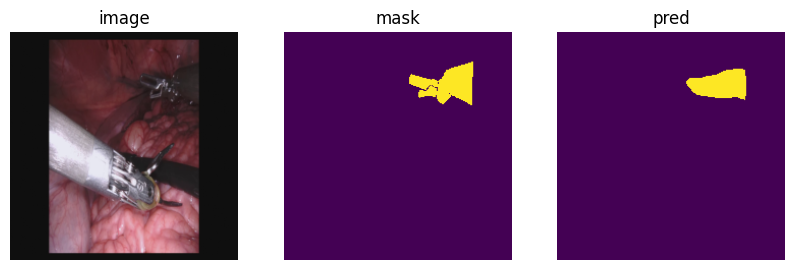

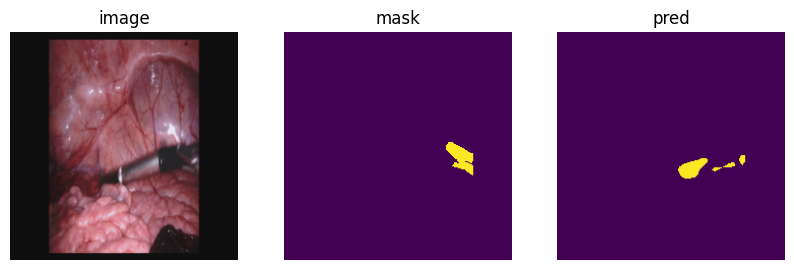

In [13]:
import matplotlib.pyplot as plt
import torch

model.eval()
imgs, gts, preds = [], [], []
with torch.inference_mode():
    for i, (x, y) in enumerate(test_loader):
        if i >= 3:
            break
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(1).cpu()
        imgs.append(x.cpu()[0].permute(1,2,0).numpy())
        gts.append(y[0].cpu().numpy())
        preds.append(pred[0].numpy())

for i in range(len(imgs)):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.title('image'); plt.axis('off'); plt.imshow(imgs[i])
    plt.subplot(1,3,2); plt.title('mask');  plt.axis('off'); plt.imshow(gts[i])
    plt.subplot(1,3,3); plt.title('pred');  plt.axis('off'); plt.imshow(preds[i])
    plt.show()

## 9) Load best checkpoint later (optional)

In [ ]:
# Example of restoring the best ckpt
# import torch
# ckpt = torch.load(best_path, map_location='cpu')
# model.load_state_dict(ckpt['model'])
# print('Restored from', best_path)

## 10) Save metrics to JSON (optional)

In [ ]:
import json, time, os
metrics_path = os.path.join(CKPT_DIR, f'metrics_{int(time.time())}.json')
with open(metrics_path, 'w') as f:
    json.dump({'mean_iou': float(mean_iou), 'mean_dice': float(mean_dice)}, f, indent=2)
print('Saved metrics to:', metrics_path)